In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df=pd.read_csv('/datc/opschaler/combined_gas_smart_weather_dfs/processed/P01S01W6495_10s.csv',header=0,delimiter='\t', parse_dates=['datetime'])
df=df.set_index(['datetime'])
dwelling_id = 'P01S02W4953'



/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def resample_df(df, sample_rate):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    """
    df = df.drop(['gasPower'], axis=1) # Drop gasPower, calculate it again later
    
    to_sum = ['eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'ePower', 'ePowerReturn'] # resampler.sum() these columns
    to_last = ['gasMeter', 'eMeter'] # resample.last(), take last known value from the columns
    
    df[to_sum] = df[to_sum].resample(sample_rate).sum() # sum values
    df[to_last] = df[to_last].resample(sample_rate).last() # take last value moest nearby the sample_rate
    df = df.resample(sample_rate).mean() # resample to 1H by mean (this wont change the values calculated by .sum() and .last())
    
    # Calculate gasPower
    df['gasPower'] = df['gasMeter'].diff()
    df['gasPower'][0] = df['gasPower'][1] # Replace 1st entry (NaN) with 2nd entry
    
    return df

In [3]:
df = df.dropna()
data = df[df['T'] < 16]

In [4]:
df1h =  resample_df(data, 'H')
df3h = resample_df(data, '3H')
df6h = resample_df(data, '6H')
df12h = resample_df(data, '12H')
df1d = resample_df(data, 'D')
df1w = resample_df(data, '7D')
df1mon = resample_df(data, '1M')



In [5]:
df1d = df1d.dropna()
df1d.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-26,1294.267944,0.0,1.275958e+07,0.0,784614.0,0.0,925.500000,261.082328,38.724211,2.995308,...,226.266199,0.105789,4.083605,6.071813,5.820795,2.153181,76.898830,35023.563743,11.665029,1.169006
2017-04-27,1294.267944,0.0,1.278671e+07,0.0,1841461.5,0.0,926.771973,232.796411,19.746551,2.997137,...,201.897007,0.035960,2.672648,6.187900,5.926946,2.129051,76.093874,36482.639701,11.496844,1.271973
2017-04-28,1299.234009,0.0,1.282288e+07,0.0,2182727.0,0.0,927.796997,266.525847,55.913999,3.000004,...,185.190816,0.138116,2.742018,7.961697,7.914419,4.362760,78.588222,33679.773312,18.080977,1.025024
2017-04-29,1299.234009,0.0,1.283995e+07,0.0,2110602.5,0.0,928.280029,160.460066,0.000000,1.830047,...,176.754123,0.000000,2.959404,7.944789,6.791098,3.221874,74.003860,33290.104106,1.986782,0.483032
2017-04-30,1299.234009,0.0,8.414873e+06,0.0,985067.0,0.0,928.664978,101.668421,0.000000,5.269033,...,156.679735,0.000000,3.442821,9.358987,7.504923,1.846617,60.395990,42059.219477,2.158969,0.384949


In [6]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    %matplotlib inline
    corr = df.corr()
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    
    fig.show()
    
    return fig

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


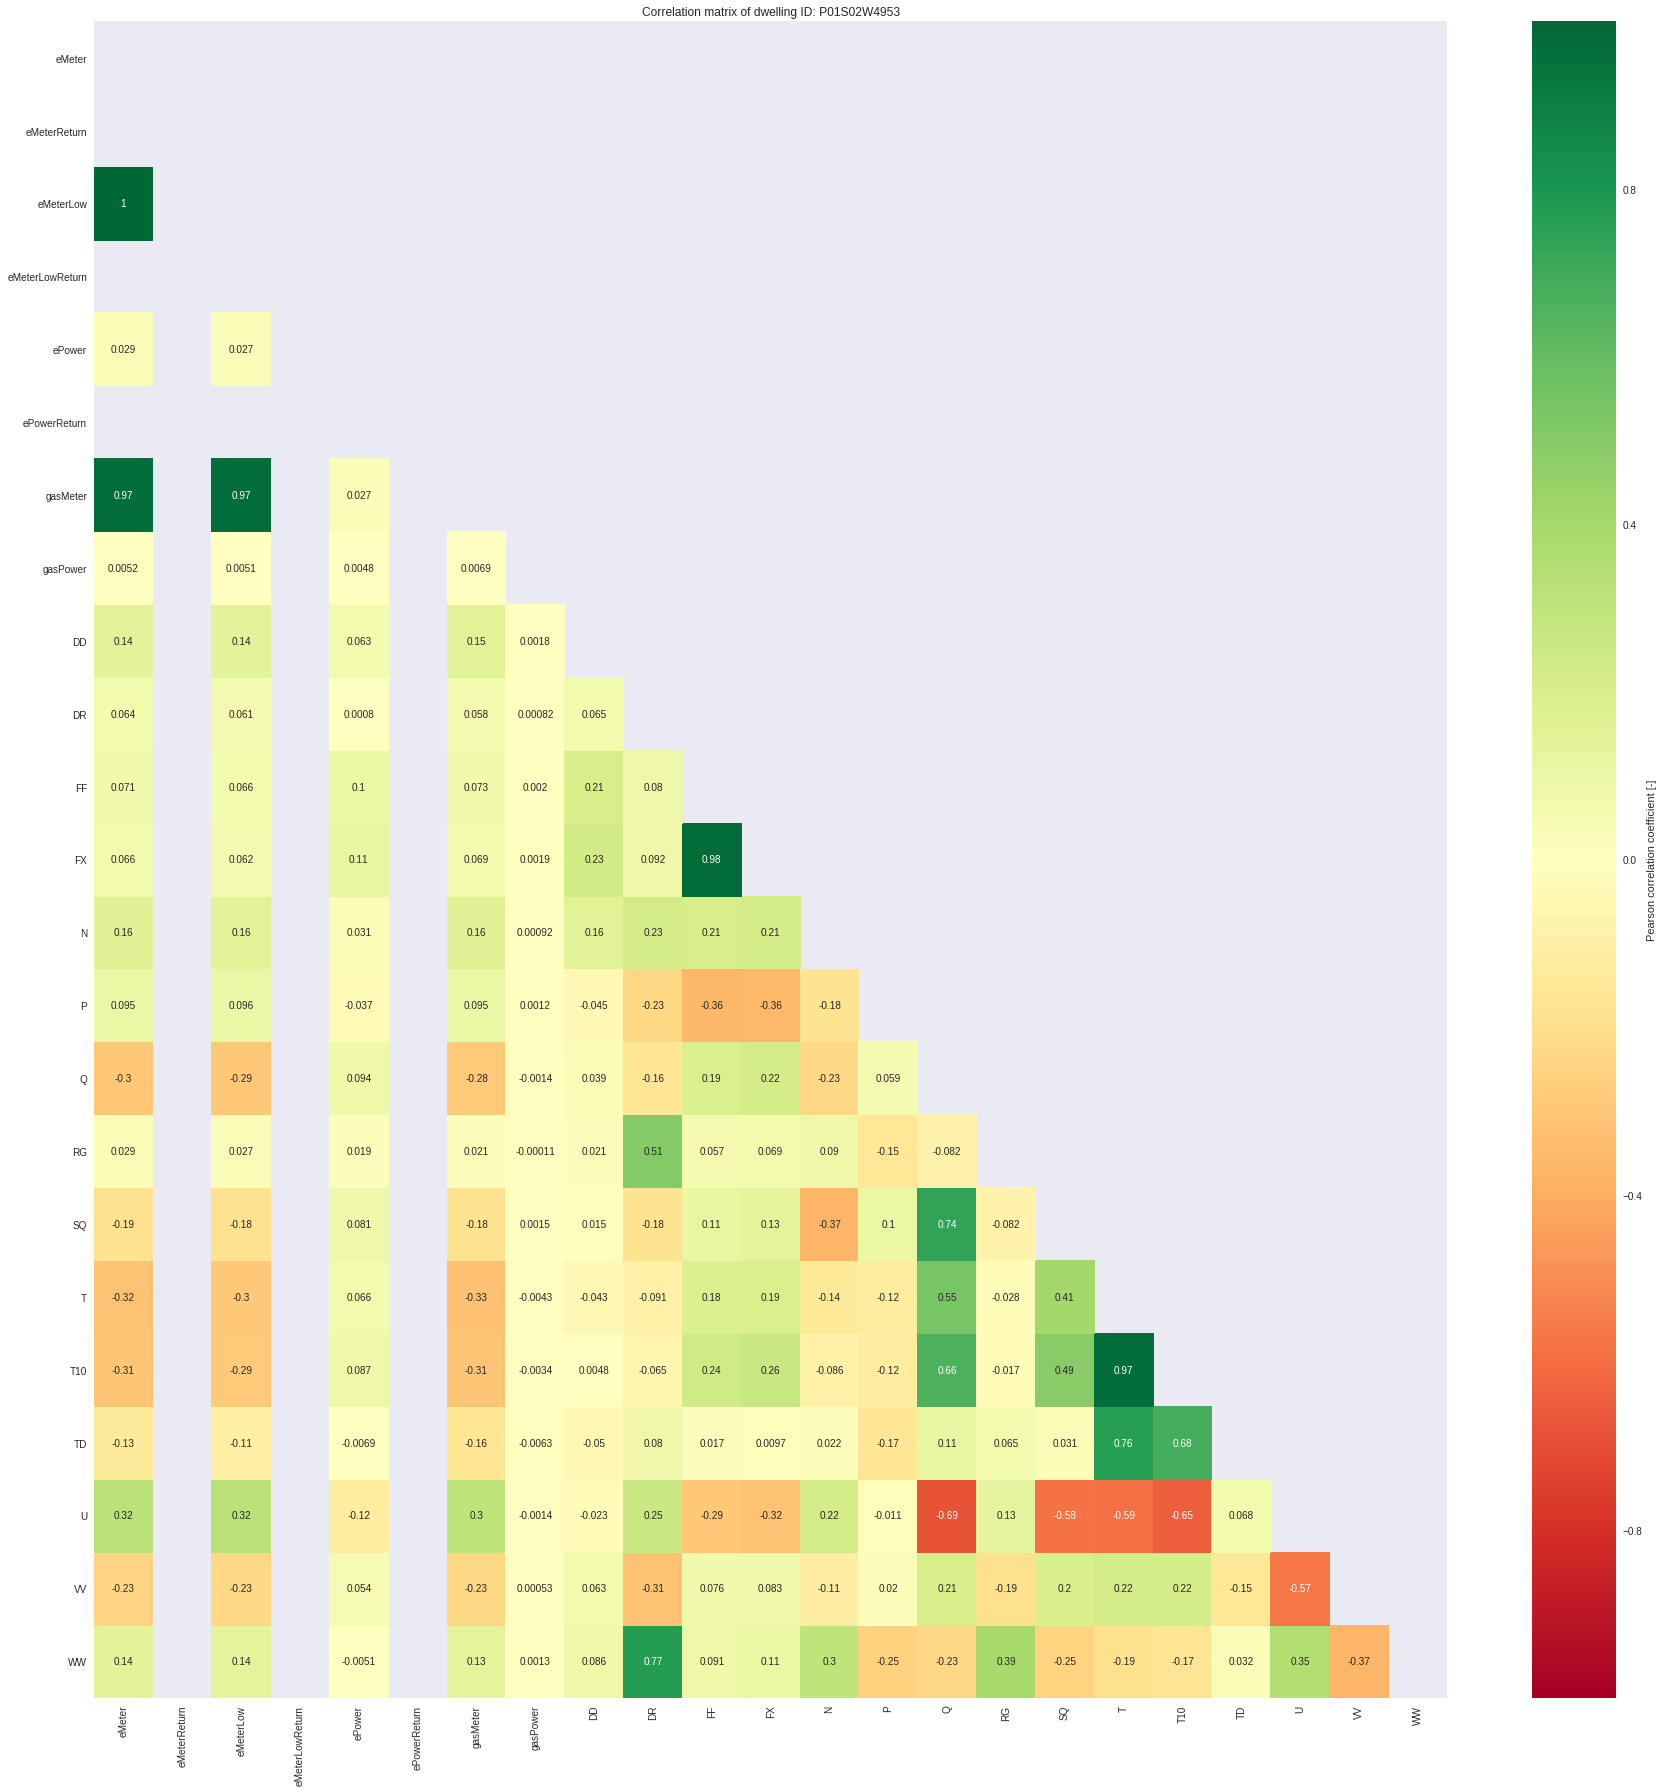

In [7]:
fig = create_corr_matrix(df, dwelling_id, True)

In [12]:
X = df1d[['T']]
Y = df1d['gasPower']
 
X = sm.add_constant(X) 

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
print('\n==============================================================================\nCOEFFICIENTES\n------------------------------------------------------------------------------\n ')
print(model.params)
print('\n==============================================================================\nMEAN SQUARED ERROR\n------------------------------------------------------------------------------\n ')
print(model.mse_total)

                            OLS Regression Results                            
Dep. Variable:               gasPower   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 09 Oct 2018   Prob (F-statistic):                nan
Time:                        15:36:35   Log-Likelihood:                    nan
No. Observations:                   5   AIC:                               nan
Df Residuals:                       3   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [9]:
[b,a]=model.params
print('Y = '+str(round(a,3))+'*T + '+str(round(b,3)))

Y = -0.208*T + 3.169


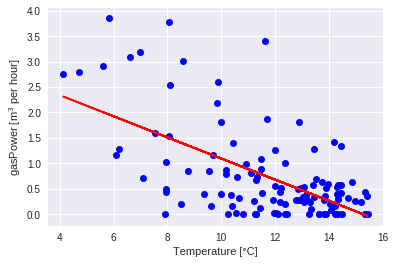

In [10]:
xx=df1d['T']
yy=a*xx+b

plt.plot(df1d['T'],df1d['gasPower'],'ob',xx,yy,'-r')
plt.grid(True)
plt.xlabel('Temperature [°C]')
plt.ylabel('gasPower [m$^3$ per hour]')
plt.show()

In [11]:
P

NameError: name 'P' is not defined